# Урок 7. Классификация с помощью kNN. Кластеризация K-means

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

Логичным усовершенствованием алгоритма kNN является добавление соседям весов (так называемое "взвешенное голосование"), зависящих от их порядкового номера или расстояния до классифицируемого объекта (чем ближе объект обучающей выборки, тем больше его вес).

От номера соседа $i$ веса можно определять как:

- $w(i) = q^{i}$,   $q \in (0,1)$;


- $w(i) = \frac{1}{i}$;


- $w(i) = \frac{1}{(i+a)^{b}}$;


- $w(i) = \frac{k + 1 - i}{k}$.


От расстояния $d$ веса можно определять как:

- $w(d) = q^{d}$,   $q \in (0,1)$;


- $w(d) = \frac{1}{(d+a)^{b}}$, брать вес $\frac{1}{d}$ по аналогии с номером соседа - неудачное решение, так как при $d = 0$ вес будет бесконечно большим, что приводит к переобучению


- $w(d) = \begin{cases}
\frac{d(z_{k}, x) - d(z_{i}, x)}{d(z_{k}, x) - d(z_{1}, x)}, & d(z_{k}, x) \neq d(z_{1}, x) \\ 
1, & d(z_{k}, x) = d(z_{1}, x)
\end{cases}$.

Существуют и другие способы вычисления весов.

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 14})

Загрузим один из "игрушечных" датасетов из sklearn.

In [3]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

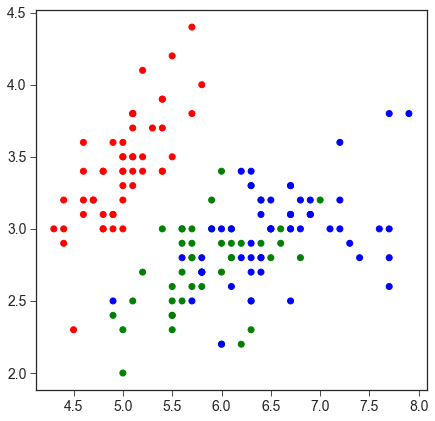

In [5]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [6]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [7]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [8]:
def accuracy(pred, y):
    return sum(pred == y) / len(y)

def knn_weighed(x_train, y_train, x_test, k, weight='lambda i: 1'):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и отбираем первые k элементов
        k_neighbors = sorted(test_distances)[0:k]
        #print(k_neighbors)
        
        # Считаем веса соседей
        w_neighbors = [(eval(weight), d, y)  for i, (d, y) in enumerate(k_neighbors, start=1)]
        #print(w_neighbors)
        
        k_inv_distances = np.zeros(k) # обратные расстояния
        sum_inv_dist = 0.0 # сумма обратных расстояний
        for i in range(k):
            k_inv_distances[i] = 1.0 / (k_neighbors[i][0] + 1e-17)
            sum_inv_dist += k_inv_distances[i]
        #print(k_inv_distances, sum_inv_dist)
        
        # Заполняем словарик весами
        for d in w_neighbors:
            classes[d[2]] += d[0]
            '''Варианты весов:
                classes[d[1]] += 1 / i 
                classes[d[1]] += (1 + 1 / i ) 
                classes[d[1]] += (k + 1 - i) / k 
                classes[d[1]] += 0.9 ** i 
                classes[d[1]] += 0.9 ** d[0] 
                classes[d[1]] += k_inv_distances[i] / sum_inv_dist 
                classes[d[1]] += np.sqrt(d[0]) 
                classes[d[1]] += (1. / (d[0] + 1e-17)) 
            '''
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Проверим работу алгоритма при различных k

In [9]:
weights = ['(lambda i: 1)(i)', 
           '(lambda i: 1 / i)(i)', 
           '(lambda i: (k + 1 - i) / k)(i)', 
           #'(lambda i: 1 + 1 / i)(i)', 
           '(lambda i: 0.9 ** i)(i)',
           '(lambda d: 0.9 ** d)(d)'
]
k_list = list(range(1, 10)) + list(range(10, 100, 10))
pred = {}
metrics = {}
for j, w in enumerate(weights):
    y_pred = []
    y_metrics = []
    for k in k_list:
        y_pred.append(knn_weighed(X_train, y_train, X_test, k, weight=w))
        y_metrics.append(accuracy(y_pred[-1], y_test))
        #print(f'Точность алгоритма при k = {k}: {y_metrics[-1]:.3f}')
    pred[j] = y_pred
    metrics[j] = y_metrics

Построим график изменения точности при разных вариантах весов.

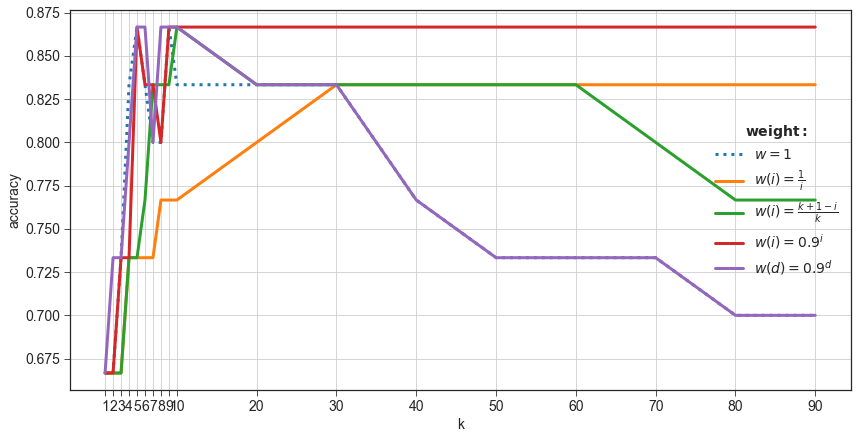

In [10]:
weights_labels = [
    r'$w = 1$',
    r'$w(i) = \frac{1}{i}$',
    r'$w(i) = \frac{k + 1 - i}{k}$',
    #r'$w(i) = 1+\frac{1}{i}$',
    r'$w(i) = 0.9^{i}$',
    r'$w(d) = 0.9^{d}$'
]

axis_parameters = {
    'xlabel': 'k',
    'ylabel': 'accuracy',
    'xticks': k_list
}

plot_parameters = [
    {'label': label} for label in weights_labels
]
_, axis = plt.subplots(figsize=(14, 7))

for j in range(len(weights)):
    fmt = ':' if j == 0 else '-'
    axis.plot(k_list, metrics[j], fmt, linewidth=3,
          **plot_parameters[j]
             )
axis.set(**axis_parameters)
axis.legend(title='$\\bf{weight:}$')
axis.grid();

Неплохую точность показывает алгоритм с весами $w(i)=0.9^i$, начиная с `k=9`, или с весами $w(d)=0.9^d$ при `k=4, 5, 8, 9, 10`.